# Chapter 11: Quantum Linear Algebra

Hadamard tests, swap tests, and measurement overhead analysis.

---

**Prerequisites:**
- See `Chapter02_QuantumSoftware.ipynb` for installation instructions


In [1]:
# Setup and imports
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import UnitaryGate, QFTGate
from qiskit.circuit.library import QFT, phase_estimation, HamiltonianGate
from qiskit.quantum_info import SparsePauliOp
from Chapter03_EngineeringOptimization_functions import PlaneStressCantilever
from qiskit.circuit.library import  StatePreparation,DiagonalGate, ZGate, XGate
from Chapter08_QuantumGates_functions import simulate_statevector, simulate_measurements #type: ignore

from Chapter11_QLA_functions import (ryMatrix, rzMatrix,hadamards, 
                                              woodbury_rank1_query,inner_product_estimation, PrepSelectUnprep)



## Encoding a vector

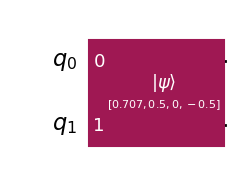

In [2]:

x = np.array([np.sqrt(2), 1, 0,-1])
n = int(np.ceil(np.log2(len(x))))
# Normalize the vector 
x = x / np.linalg.norm(x)

# Create circuit and prepare state
qc = QuantumCircuit(n)
qc.initialize(x, range(n))
display(qc.draw('mpl'))

## PREP-SELECT-UNPREP A*x for 2x2 matrix 

LCU Result:  [ 2.  -0.1]
Classical:   [ 2.  -0.1]


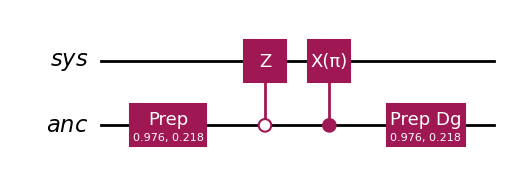

In [3]:
# 1. Define A and |x>
# A = 2Z - 0.1X
A = np.array([
    [2, -0.1],
    [-0.1, -2]
], dtype=float)

x = np.array([1, 0], dtype=complex)  # |0> state
expected_output = A @ x

# 2. Hardcoded decomposition: A = 2*Z + (-0.1)*X
c0, c1 = 2.0, -0.1
alpha = np.abs(c0) + np.abs(c1)  # 2.1

num_ancilla = 1
num_system = 1

qr_sys = QuantumRegister(num_system, 'sys')
qr_anc = QuantumRegister(num_ancilla, 'anc')
qc = QuantumCircuit(qr_sys, qr_anc)  # System on top, ancilla on bottom

# 3. PREP: Encode sqrt(|c0|/alpha), sqrt(|c1|/alpha)
prep_vec = np.array([np.sqrt(np.abs(c0)/alpha), np.sqrt(np.abs(c1)/alpha)])
prep_gate = StatePreparation(prep_vec, label='Prep')
qc.append(prep_gate, qr_anc)


# 4. SELECT: Apply controlled unitaries

# Term 0: Controlled-Z when ancilla = |0⟩, coefficient c0 = 2.0
phase0 = np.angle(c0)  # 0
gate_circ_0 = QuantumCircuit(num_system, global_phase=phase0)
gate_circ_0.append(ZGate(), [0])
ctrl_z = gate_circ_0.to_gate(label='Z').control(
    num_ctrl_qubits=num_ancilla,
    ctrl_state='0'
)
qc.append(ctrl_z, [qr_anc[0], qr_sys[0]])


# Term 1: Controlled-X when ancilla = |1⟩, coefficient c1 = -0.1
phase1 = np.angle(c1)  # π
gate_circ_1 = QuantumCircuit(num_system, global_phase=phase1)
gate_circ_1.append(XGate(), [0])
ctrl_x = gate_circ_1.to_gate(label='X(π)').control(
    num_ctrl_qubits=num_ancilla,
    ctrl_state='1'
)
qc.append(ctrl_x, [qr_anc[0], qr_sys[0]])

# 5. UNPREP
qc.append(prep_gate.inverse(), qr_anc)

# 6. Simulate and post-select
full_init = Statevector.from_label('0' * num_ancilla).expand(Statevector(x))
final_sv = full_init.evolve(qc)

# Post-selection: ancilla = |0⟩
stride = 2**num_ancilla

res_vector = final_sv.data[0:2**num_system] * alpha
print("="*50)
print("LCU Result: ", np.round(np.real_if_close(res_vector), 4))
print("Classical:  ", np.round(np.real_if_close(expected_output), 4))
print("="*50)

qc.draw('mpl')

## Pauli Expansion

In [4]:
A = np.array([
    [1, 0, 0, -0.5],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [-0.5, 0, 0, 1]
])
pauliSplit = SparsePauliOp.from_operator(A)
print(pauliSplit.paulis)
print(pauliSplit.coeffs)

['II', 'XX', 'YY']
[ 1.  +0.j -0.25+0.j  0.25-0.j]


## Generic PREP-SELECT-UNPREP

LCU Result:  [ 0.6  0.8 -0.  -0.3]


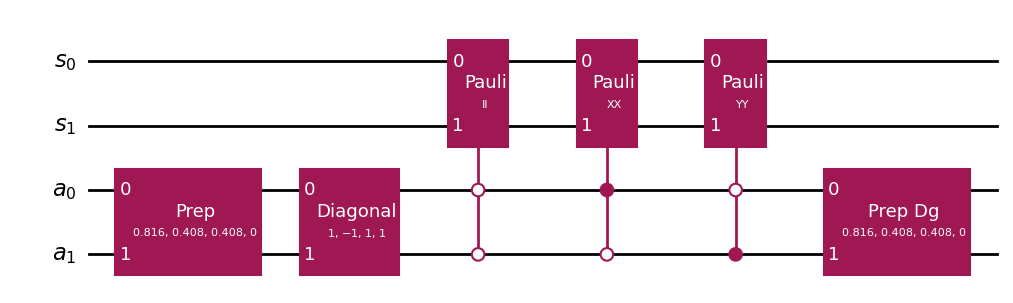

In [ ]:
A = np.array([
    [1, 0, 0, -0.5],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [-0.5, 0, 0, 1]
], dtype=float)

x = np.array([0.6, 0.8, 0, 0], dtype=complex)
expected_output = A @ x
qc, res_vector = PrepSelectUnprep(A, x)
print("LCU Result: ", np.round(np.real_if_close(res_vector), 4))
qc.draw('mpl')

## Hadamard Tests

In [ ]:
zeroQubit = QuantumRegister(1, '0')
phiQubit = QuantumRegister(1, '\u03D5')
cl = ClassicalRegister(1,'m')
circuit = QuantumCircuit(zeroQubit,phiQubit, cl) 
circuit.h(0)
#circuit.sdg(0)
UMatrix = 1/np.sqrt(2)*np.array([[1,1],[1j,-1j]]) 
U = UnitaryGate(UMatrix,'U')
UControl = U.control(1)
circuit.append(UControl,[0,1])
circuit.h(0)
circuit.measure(0,0) 
display(circuit.draw('mpl'))
counts = simulate_measurements(circuit,shots = 1000)
print('Counts:',counts)

### Inner Product

In [ ]:
circuit = QuantumCircuit(2, 1) 
circuit.h(0)
a = np.sqrt(3)
b = 1/np.sqrt(2)
UMatrix = b*np.array([[(a+1)/2,(a-1)/2],[(a-1)/2,(-a-1)/2]])
U = UnitaryGate(UMatrix,'U')
UControl = U.control(1)
circuit.append(UControl,[0,1])
circuit.h(0)
circuit.measure(0,0) 
display(circuit.draw('mpl'))
counts = simulate_measurements(circuit,shots = 100)
print('Counts:',counts)

### Inner Product-Real

In [ ]:

U_phi = ryMatrix(2*np.pi/3)
U_psi = ryMatrix(np.pi/3)
UMatrix = np.matmul(U_phi.conj().T,U_psi)

circuit = QuantumCircuit(2, 1) 
circuit.h(0)
U = UnitaryGate(UMatrix,'U')
UControl = U.control(1)
circuit.append(UControl,[0,1])
circuit.h(0)
circuit.measure(0,0) 
display(circuit.draw('mpl'))
shots = 10000
counts = simulate_measurements(circuit,shots =shots)

dotprod = 2*counts['0']/shots - 1
print('dotprod:',dotprod)

### Inner product: Imaginary

In [ ]:

	
U_phi = ryMatrix(2*np.pi/3)
U_psi = rzMatrix(-np.pi)
UMatrix = np.matmul(U_phi.conj().T,U_psi)
phi = np.matmul(U_phi,np.array([1,0]))
psi = np.matmul(U_psi,np.array([1,0]))
print('Exact:', np.dot(phi,psi))

circuit = QuantumCircuit(2, 1) 
circuit.h(0)
circuit.sdg(0)
U = UnitaryGate(UMatrix,'U')
UControl = U.control(1)
circuit.append(UControl,[0,1])
circuit.h(0)
circuit.measure(0,0) 
circuit.draw('mpl')
shots = 10000
counts = simulate_measurements(circuit,shots = shots)

dotprod = (counts['0'] - counts['1'])/shots
print('dotprod:',dotprod)

### Inner product: Negative Real

In [ ]:
def ryMatrix(alpha):
	return np.array([[np.cos(alpha/2), -np.sin(alpha/2)], [np.sin(alpha/2), np.cos(alpha/2)]])
	
U_phi = ryMatrix(2*np.pi/3)
U_psi = ryMatrix(5*np.pi/2)

phi = np.matmul(U_phi,np.array([1,0]))
psi = np.matmul(U_psi,np.array([1,0]))
print('Exact:', np.dot(phi,psi))
UMatrix = np.matmul(U_phi.conj().T,U_psi)

circuit = QuantumCircuit(2, 1) 
circuit.h(0)
U = UnitaryGate(UMatrix,'U')
UControl = U.control(1)
circuit.append(UControl,[0,1])
circuit.h(0)
circuit.measure(0,0) 
display(circuit.draw('mpl'))
shots = 10000
counts = simulate_measurements(circuit,shots = shots)

dotprod = (counts['0'] - counts['1'])/shots
print('dotprod:',dotprod)

### Swap test concept

In [ ]:
zeroQubit = QuantumRegister(1, '0')
psiQubit = QuantumRegister(1, '\u03C8')
phiQubit = QuantumRegister(1, '\u03D5')
cl = ClassicalRegister(1,'m')
circuit = QuantumCircuit(zeroQubit,phiQubit,psiQubit,cl) 
circuit.h(0)

circuit.cswap(zeroQubit, psiQubit, phiQubit)
circuit.h(0)
circuit.measure(0,0) 
display(circuit.draw('mpl')) 


### Swap test example

In [ ]:
circuit = QuantumCircuit(3,1) 
circuit.h(0)
circuit.ry(2*np.pi/3, 1)
circuit.h(2)
circuit.cswap(0, 1, 2)
circuit.h(0)
circuit.measure(0,0) 
display(circuit.draw('mpl')) 
counts = simulate_measurements(circuit,shots = 10000)
print('Counts:',counts)

P0 = (counts['0'])/10000
print('dotprodSqr:',2*P0-1)

## Woodbury equation
A demo from the paper " A near-term quantum algorithm for solving linear systems of equations based on the woodbury identity", O'Malley, et. al, 2022. arXiv preprint arXiv:2205.00645.


In [ ]:
# Problem: (I + u*v^T)x = b, compute <z|x>
n = 3  # 3 qubits = 8-dimensional vectors

z_prep = hadamards(n)  # Query vector |z>
b_prep = hadamards(n)  # RHS |b>
v_prep = hadamards(n)  # Update |v>
u_prep = hadamards(n)  # Update |u>

# Woodbury parameters
alpha = 1.0
beta = 1.0

# Run quantum algorithm
result = woodbury_rank1_query(
    z_prep, b_prep, v_prep, u_prep, 
    alpha, beta, 
    shots=10
)

print(f"Quantum result: {result:.4f}")
print(f"Expected (analytical): 0.5000")  # For uniform states